<a href="https://colab.research.google.com/github/utkarshsharma1/ECG_Signals/blob/master/Utkarsh_dataset_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Do not edit**
make your own copy

In [38]:
!pip install tensorflow==2.0.0-beta1

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir


In [40]:
!pip install wfdb
import wfdb              # much needed for annotations

In [0]:
path = 'mit-bih-arrhythmia-database-1.0.0/'

In [0]:
sample_database = ['100', '101', '102', '103', '104', '105', '106', '107', '108', 
                   '109', '111', '112', '113', '114', '115', '116', '117', '118',
                   '119', '121', '122', '123', '124', '200', '201', '202', '203',
                   '205', '207', '208', '209', '210', '212', '213', '214', '215',
                   '217', '219', '220', '221', '222', '223', '228', '230', '231',
                   '232', '233', '234']

In [0]:
def load_ecg_signal(file):
    
    record = wfdb.rdrecord(file, pb_dir= 'mitdb')
    annotation = wfdb.rdann(file, 'atr', pb_dir= 'mitdb')
    
    #This gives signal
    p_signal = record.p_signal
    
    assert record.fs == 360, 'Sample frequency is not 360'
    
    #This gives symbols & annotation index
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_symbol, atr_sample

In [0]:
abnormal = ['L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']

In [0]:
def make_dataset(sample_database, no_of_sec, fs):
    
    #No of columns
    num_cols = 2 * no_of_sec * fs
    X_all = np.zeros((1, num_cols))
    Y_all = np.zeros((1,1))
    symbol_all = []
    
    max_rows = []
    
    for i in sample_database:
        #file = path + i
        print(i)
        p_signal, atr_symbol, atr_sample = load_ecg_signal(i)
        
        #Take out first signal as there are 2 signals
        p_signal = p_signal[:,0]
        
        #Make a dataframe to exclude irrevalent atr_symbol
        #atr_sample is index of annotation
        df_annotation = pd.DataFrame({'atr_symbol': atr_symbol,'atr_sample': atr_sample})
        df_annotation = df_annotation.loc[df_annotation.atr_symbol.isin(abnormal + ['N'])]
        
        #Gives no of accepted pulses
        no_of_rows = len(df_annotation)
        
        #creates matrix accordingly
        X = np.zeros((no_of_rows, num_cols))
        Y = np.zeros((no_of_rows, 1))
        
        #keep track of rows
        row_number = 0
        
        #Now iterate through the dataframe
        for atr_sample, atr_symbol in zip(df_annotation.atr_sample.values, df_annotation.atr_symbol.values):
            
            #Took min and max value in order to tackle the 2 extreme end cases
            left = max([0, (atr_sample - no_of_sec * fs)])
            right = min([len(p_signal), (atr_sample + no_of_sec * fs)])
            x = p_signal[left: right]
            
            if len(x) == num_cols:
            
                #This will store all the values of p_signal from 'left' to 'right'
                X[row_number, :] = x
                
                #This line will store 0 if its normal & 1 if its abnormal in Y
                Y[row_number, :] = int(atr_symbol in abnormal)
                
                #A list consisting of all symbols
                symbol_all.append(atr_symbol)
                row_number += 1
                
        #Reduces rows of X and Y as we remove some datas whose len(x) != num_cols
        X = X[: row_number, :]
        Y = Y[: row_number, :]
                
        #For checking dimensions       
        max_rows.append(row_number)
                
        #append X and Y from previous iteration with new data
        X_all = np.append(X_all, X, axis = 0)
        Y_all = np.append(Y_all, Y, axis = 0)
     
    #Removes first column as it contains only zeros when we initialized it
    X_all = X_all[1:, :]
    Y_all = Y_all[1:, :]
            
    
    assert np.sum(max_rows) == X_all.shape[0], 'No of rows messed 1'
    assert Y_all.shape[0] == X_all.shape[0], 'No of rows messed 2' 
    assert Y_all.shape[0] == len(symbol_all), 'No of rows messed 3'
            
    return X_all, Y_all, symbol_all

In [46]:
#Lets keep no_of_sec as -+ of 3
no_of_sec = 3
#sampling frequency is 360
fs = 360
X_all, Y_all, Symbol_all = make_dataset(sample_database, no_of_sec, fs)

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


In [47]:
print(X_all.shape, Y_all.shape, len(Symbol_all))

(109099, 2160) (109099, 1) 109099


In [48]:
np.unique(Y_all, return_counts= True)

(array([0., 1.]), array([74795, 34304]))

Y value :  [1.]


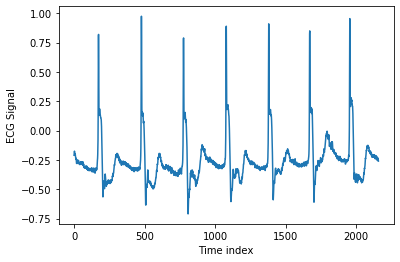

In [49]:
plt.plot(X_all[5888])
plt.xlabel('Time index')
plt.ylabel('ECG Signal')
plt.show
print('Y value : ', Y_all[5888])

In [0]:
#we naively just decided to randomly split our data by samples into a train and validation set.
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 69)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [0]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

In [0]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [54]:
model.fit(X_train, Y_train, batch_size = 32, epochs = 5, verbose = 1)

Train on 73096 samples
Epoch 1/5
73096/73096 [==============================] - 6s 81us/sample - loss: 0.2501 - accuracy: 0.9058
Epoch 2/5
73096/73096 [==============================] - 6s 81us/sample - loss: 0.1608 - accuracy: 0.9474
Epoch 3/5
73096/73096 [==============================] - 5s 70us/sample - loss: 0.1418 - accuracy: 0.9539
Epoch 4/5
73096/73096 [==============================] - 5s 71us/sample - loss: 0.1338 - accuracy: 0.9588
Epoch 5/5
73096/73096 [==============================] - 5s 71us/sample - loss: 0.1254 - accuracy: 0.9616


In [0]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calc_prevalence(Y_actual):
  return sum(Y_actual)/ len(Y_actual)

def calc_specificity(Y_actual, Y_pred, thresh):
  return sum((Y_pred < thresh) & (Y_actual == 0))/ sum(Y_actual == 0)

def print_report(Y_actual, Y_pred, thresh):

  auc = roc_auc_score(Y_actual, Y_pred)
  accuracy = accuracy_score(Y_actual, (Y_pred > thresh))
  recall = recall_score(Y_actual, (Y_pred > thresh))
  precision = precision_score(Y_actual, (Y_pred > thresh))
  specificity = calc_specificity(Y_actual, Y_pred, thresh)
  prevalence = calc_prevalence(Y_actual)
  print('AUC: %.3f' %auc)
  print('Accuracy: %.3f' %accuracy)
  print('Recall: %.3f' %recall)
  print('Precision: %.3f' %precision)
  print('Specificity: %.3f' %specificity)
  print('Prevalence: %.3f' %prevalence)
  print('')
  return auc, accuracy, recall, precision, specificity


In [56]:
Y_train_preds_dense = model.predict_proba(X_train, verbose = 1)
Y_valid_preds_dense = model.predict_proba(X_valid, verbose = 1)

36003/36003 [==============================] - 1s 28us/sample


In [57]:
#It calculates the ratio of number of values of Y_train = 0 to size of Y_train
thresh = (sum(Y_train)/ len(Y_train))[0]
thresh

0.3161732516143154

In [60]:
print('Train');
print_report(Y_train, Y_train_preds_dense, thresh)
print('Valid');
print_report(Y_valid, Y_valid_preds_dense, thresh)

Train
AUC: 0.991
Accuracy: 0.968
Recall: 0.940
Precision: 0.960
Specificity: 0.982
Prevalence: 0.316

Valid
AUC: 0.987
Accuracy: 0.964
Recall: 0.932
Precision: 0.950
Specificity: 0.978
Prevalence: 0.311



(0.987003454432009,
 0.9635585923395272,
 0.9320110783525418,
 0.9498315578621506,
 array([0.97779121]))

In [61]:
#Technically the same patient can show up in both the training and validation sets. 
#This means that we may have accidentally leaked information across the datasets. 
#We can test this idea by splitting on patients instead of samples.
import random
random.seed(27)
pts_train = random.sample(sample_database, 36)
pts_valid = [pt for pt in sample_database if pt not in pts_train]
print(len(pts_train), len(pts_valid))

36 12


In [64]:
X_train, Y_train, Sym_train = make_dataset(pts_train, no_of_sec, fs)
X_valid, Y_valid, Sym_valid = make_dataset(pts_valid, no_of_sec, fs)
print(X_train.shape, Y_train.shape, len(Sym_train))
print(X_valid.shape, Y_valid.shape, len(Sym_valid))

223
209
231
118
119
113
104
234
117
214
123
221
200
202
112
116
212
210
203
102
215
122
230
208
207
121
114
219
101
115
213
100
233
222
205
109
103
105
106
107
108
111
124
201
217
220
228
232
(84802, 2160) (84802, 1) 84802
(24297, 2160) (24297, 1) 24297


Let's try to implement CNN

In [68]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(84802, 2160, 1)
(24297, 2160, 1)


In [0]:
from tensorflow.keras.layers import Conv1D

In [0]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (X_train.shape[1], 1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [0]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [75]:
model.fit(X_train_cnn, Y_train, batch_size = 32, epochs = 5, verbose = 1)

Train on 84802 samples
Epoch 1/5
84802/84802 [==============================] - 376s 4ms/sample - loss: 0.1634 - accuracy: 0.9465
Epoch 2/5
84802/84802 [==============================] - 374s 4ms/sample - loss: 0.1009 - accuracy: 0.9682
Epoch 3/5
84802/84802 [==============================] - 373s 4ms/sample - loss: 0.0860 - accuracy: 0.9725
Epoch 4/5
84802/84802 [==============================] - 373s 4ms/sample - loss: 0.0778 - accuracy: 0.9747
Epoch 5/5
84802/84802 [==============================] - 372s 4ms/sample - loss: 0.0727 - accuracy: 0.9765


In [76]:
Y_train_preds_cnn = model.predict_proba(X_train_cnn, verbose = 1)
Y_valid_preds_cnn = model.predict_proba(X_valid_cnn, verbose = 1)

24297/24297 [==============================] - 15s 629us/sample


In [0]:
#It calculates the ratio of number of values of Y_train = 0 to size of Y_train
thresh = (sum(Y_train)/ len(Y_train))[0]
thresh

In [0]:
print('Train');
print_report(Y_train_cnn, Y_train_preds_cnn, thresh)
print('Valid');
print_report(Y_valid_cnn, Y_valid_preds_cnn, thresh)